In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

pd.set_option("display.max_columns", 50)

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# cargamo la data
dataset=pd.read_csv('drive/My Drive/Aprendizaje Automático/Proyecto AA/in-vehicle-coupon-recommendation.csv')

In [ ]:
dataset.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0


In [ ]:
dataset.isna().sum()/len(dataset)

destination             0.000000
passanger               0.000000
weather                 0.000000
temperature             0.000000
time                    0.000000
coupon                  0.000000
expiration              0.000000
gender                  0.000000
age                     0.000000
maritalStatus           0.000000
has_children            0.000000
education               0.000000
occupation              0.000000
income                  0.000000
car                     0.991485
Bar                     0.008436
CoffeeHouse             0.017108
CarryAway               0.011905
RestaurantLessThan20    0.010249
Restaurant20To50        0.014901
toCoupon_GEQ5min        0.000000
toCoupon_GEQ15min       0.000000
toCoupon_GEQ25min       0.000000
direction_same          0.000000
direction_opp           0.000000
Y                       0.000000
dtype: float64

##Prepocesamiento

In [ ]:
def preprocess_dataset(dataset, save_metadata=True):
  preprocessed_dataset = dataset.copy()
  
  #Eliminamos la variable "toCoupon_GEQ5min"
  preprocessed_dataset.drop("toCoupon_GEQ5min", axis=1, inplace=True)

  #Eliminamos la variable "direction_same"
  preprocessed_dataset.drop("direction_same", axis=1, inplace=True)

  #Determinamos aquellas variables que tengan un porcentaje de registros nulos por cada variable mayor al valor de 0.7
  threshold = 0.7
  null_percentages = preprocessed_dataset.isna().sum() / len(preprocessed_dataset)
  criteria = null_percentages > threshold
  columns_to_filter = null_percentages[criteria].keys()

  #Eliminamos las variables seleccionadas en el paso anterior
  preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)

  #Eliminamos los registros duplicados
  preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  #Determinamos que variables son del tipo númerico y cuales son categóricas
  numeric_columns = list()
  categorical_columns = list()
  dictionary_of_columns_with_index_to_categorical = dict()
  dictionary_of_columns_with_categorical_to_index = dict()

  for column in preprocessed_dataset:
      #Determinamos si la variable es numérica o no
      if pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
        numeric_columns.append(column)
      else:
        #Modificamos el tipo de dato de la variable mediante "astype"
        preprocessed_dataset[column] = preprocessed_dataset[column].astype("category")

        #Verificamos si el tipo de dato de la variable fue transformado a categórico correctamente
        if not pd.api.types.is_categorical_dtype(preprocessed_dataset[column]):
          raise Exception("La columna {} no se transformó correctamente a categórica".format(column))

        dictionary_of_columns_with_index_to_categorical[column] = dict()
        dictionary_of_columns_with_categorical_to_index[column] = dict()
        
        #Indexamos los valores (categorías), sin tomar en consideración los nulos, de la variable y guardamos esa información en los diccionarios
        for index, category in enumerate(preprocessed_dataset[column].cat.categories):
          dictionary_of_columns_with_index_to_categorical[column][index] = category
          dictionary_of_columns_with_categorical_to_index[column][category] = index
        
        categorical_columns.append(column)
    
  #Reemplazamos los nulos con la mediana sólo de aquellas variables numéricas
  median_of_numeric_columns = preprocessed_dataset[numeric_columns].median()

  preprocessed_dataset[numeric_columns] = preprocessed_dataset[numeric_columns].fillna(median_of_numeric_columns)

  #Transformamos a números los valores (categorías) de las variables categóricas sin considerar los nulos
  preprocessed_dataset.replace(dictionary_of_columns_with_categorical_to_index, inplace=True)

  #Generamos una nueva lista de variables categóricas y las variables eliminadas por tener un porcentaje alto de registros nulos
  categorical_columns_filtered = categorical_columns[:]
  
  if len(categorical_columns_filtered) > 0:
    #Reemplazamos los nulos con la mediana para todas las variables y las variables eliminadas por tener un porcentaje alto de registros nulos
    median_of_categorical_columns = preprocessed_dataset[categorical_columns_filtered].median()

    preprocessed_dataset[categorical_columns_filtered] = preprocessed_dataset[categorical_columns_filtered].fillna(median_of_categorical_columns)
  
  if save_metadata:
    #Guardamos información que consideremos imporante. El formato pickle nos permite guardar objetos de python
    with open("numeric_columns.pkl", "wb") as f:
      pickle.dump(numeric_columns, f)
    
    with open("categorical_columns.pkl", "wb") as f:
      pickle.dump(categorical_columns, f)
    
    with open("dictionary_of_columns_with_index_to_categorical.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_index_to_categorical, f)
    
    with open("dictionary_of_columns_with_categorical_to_index.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_categorical_to_index, f)
      
  return preprocessed_dataset

In [ ]:
# Preprocesamos los datos   
preprocess_dataset=preprocess_dataset(dataset)

In [ ]:
#guadarmos nuestro dataset pre-procesado en formato pickle  
preprocess_dataset.to_pickle("preprocessed_dataset_in_vehicle_train.pkl")

In [ ]:
preprocess_dataset.shape

(12610, 23)

In [ ]:
preprocess_dataset.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_opp,Y
0,1,0,2,55,2,4,0,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,0,0,1,1
1,1,1,2,80,0,2,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,0,0,1,0
2,1,1,2,80,0,1,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,1
3,1,1,2,80,2,2,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,0
4,1,1,2,80,2,2,0,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,0


In [ ]:
#Cargamos los datos previamente guardados
with open("numeric_columns.pkl", "rb") as f:
    numeric_columns = pickle.load(f)

with open("categorical_columns.pkl", "rb") as f:
  categorical_columns = pickle.load(f)

with open("dictionary_of_columns_with_index_to_categorical.pkl", "rb") as f:
  dictionary_of_columns_with_index_to_categorical = pickle.load(f)

with open("dictionary_of_columns_with_categorical_to_index.pkl", "rb") as f:
  dictionary_of_columns_with_categorical_to_index = pickle.load(f)

preprocessed_dataset = pd.read_pickle("preprocessed_dataset_in_vehicle_train.pkl")

In [ ]:
dictionary_of_columns_with_categorical_to_index

{'Bar': {'1~3': 0, '4~8': 1, 'gt8': 2, 'less1': 3, 'never': 4},
 'CarryAway': {'1~3': 0, '4~8': 1, 'gt8': 2, 'less1': 3, 'never': 4},
 'CoffeeHouse': {'1~3': 0, '4~8': 1, 'gt8': 2, 'less1': 3, 'never': 4},
 'Restaurant20To50': {'1~3': 0, '4~8': 1, 'gt8': 2, 'less1': 3, 'never': 4},
 'RestaurantLessThan20': {'1~3': 0,
  '4~8': 1,
  'gt8': 2,
  'less1': 3,
  'never': 4},
 'age': {'21': 0,
  '26': 1,
  '31': 2,
  '36': 3,
  '41': 4,
  '46': 5,
  '50plus': 6,
  'below21': 7},
 'coupon': {'Bar': 0,
  'Carry out & Take away': 1,
  'Coffee House': 2,
  'Restaurant(20-50)': 3,
  'Restaurant(<20)': 4},
 'destination': {'Home': 0, 'No Urgent Place': 1, 'Work': 2},
 'education': {'Associates degree': 0,
  'Bachelors degree': 1,
  'Graduate degree (Masters or Doctorate)': 2,
  'High School Graduate': 3,
  'Some High School': 4,
  'Some college - no degree': 5},
 'expiration': {'1d': 0, '2h': 1},
 'gender': {'Female': 0, 'Male': 1},
 'income': {'$100000 or More': 0,
  '$12500 - $24999': 1,
  '$2500

##Visualización de datos

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

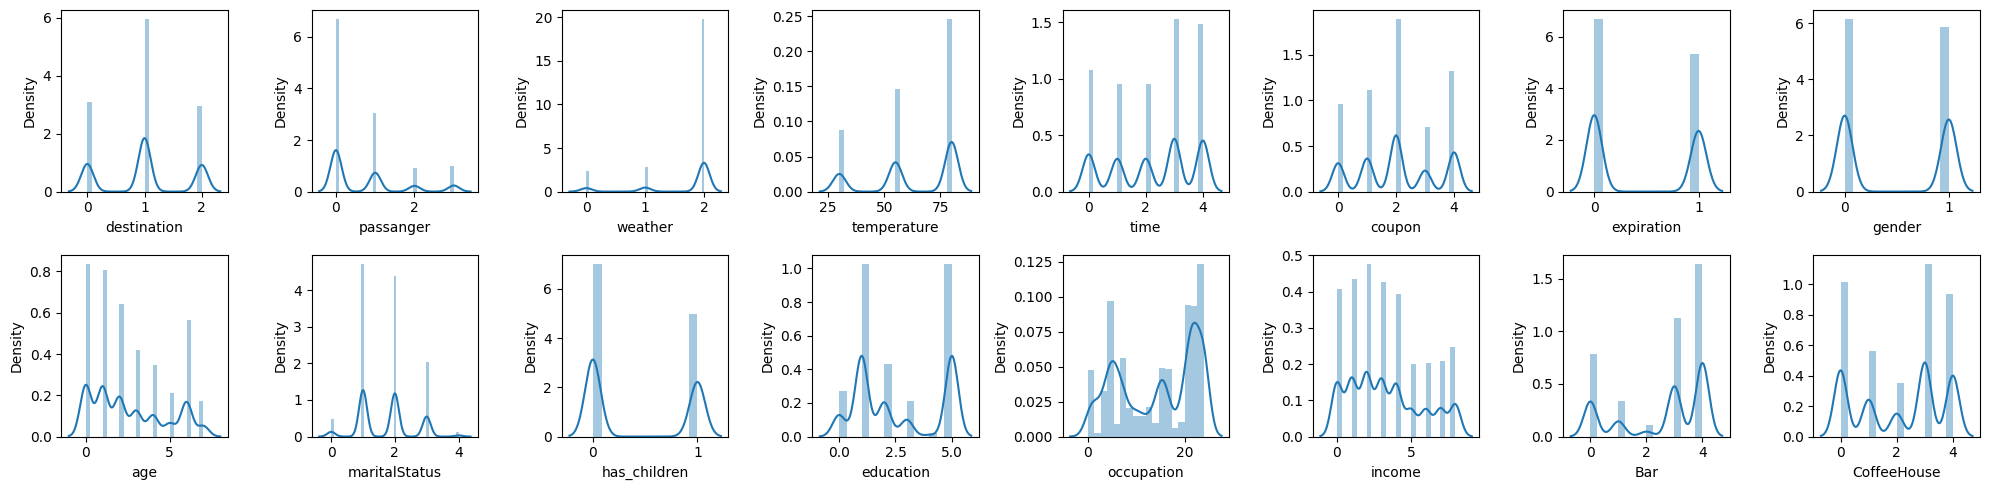

In [ ]:
width=20
height=5

plt.style.use('default');
figure, axes = plt.subplots(nrows=2,ncols=8, figsize=(width,height))

for column, axe in zip(preprocess_dataset, axes.flatten()):
  sns.distplot(preprocess_dataset[column],ax=axe)

plt.tight_layout()

##División de datos

In [ ]:
#Separamos la data, en variables independientes (x) y dependientes (y), para poder entrenar un árbol de clasificación
x = preprocessed_dataset.drop("Y", axis=1)
y = preprocessed_dataset["Y"]

In [ ]:
x.head()

##Separamos datos para entrenamiento y prueba

In [ ]:
#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. El parámetro "random state" nos sirve para
x_train,x_test,y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=0,stratify=y)


In [ ]:
print(f"Train Shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

Train Shape: (10088, 22)
Test shape: (2522, 22)


##Entrenamiento y verificación con CART

In [ ]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=3)

In [ ]:
#Podemos verificar las etiquetas que tuvo que predecir nuestro árbol de clasificación
print("Etiquetas a predecir: {}".format(set(y_train)))

print("Etiquetas predecidas: {}".format(model.classes_))

Etiquetas a predecir: {0, 1}
Etiquetas predecidas: [0 1]


In [ ]:
#La exactitud (accuracy) obtenido con los datos de entramiento
model.score(x_train,y_train) 

0.6471054718477399

##Visualización del árbol

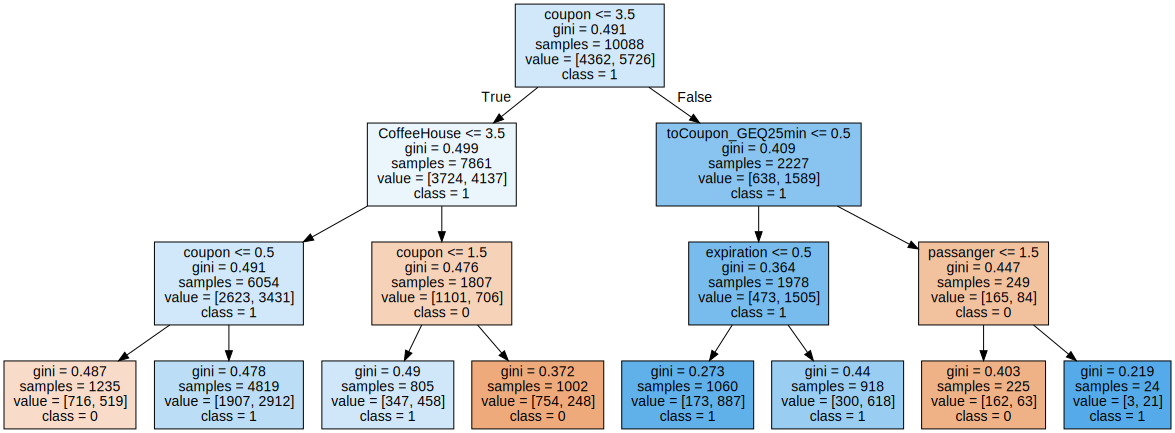

In [ ]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

classes = [(str(model_class) if isinstance(model_class, np.integer) else model_class) for model_class in model.classes_]

graph = Source(export_graphviz(model, feature_names=x.columns, class_names=classes, filled=True))

SVG(graph.pipe(format="svg"))

In [ ]:
#Escogemos un registro al azar para comprobar los datos en el árbol
val=x_train.sample()
val

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_opp
11871,1,1,2,55,1,0,1,0,0,1,1,5,21,2,3.0,0.0,1.0,0.0,4.0,1,0,1


In [ ]:
# probalidad que la persona elegidad al azar cangee el cupon
model.predict_proba(val)

array([[0.57975709, 0.42024291]])

In [ ]:
# Predecir la respuesta para el conjunto de datos de prueba
y_predic = model.predict(x_test)

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

           0       0.64      0.38      0.47      1091
           1       0.64      0.84      0.73      1431

    accuracy                           0.64      2522
   macro avg       0.64      0.61      0.60      2522
weighted avg       0.64      0.64      0.62      2522



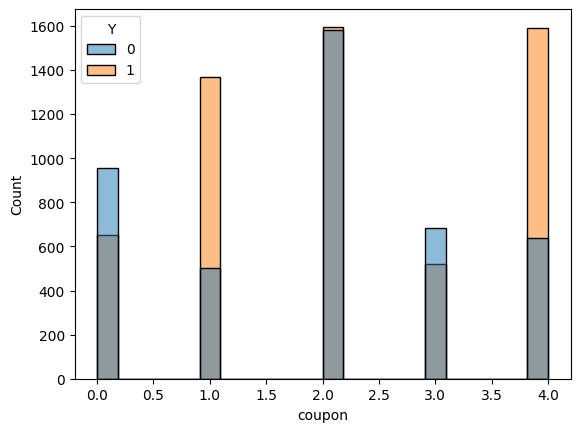

In [ ]:
#Como el modelo elige la variable cupon como punto de decision
# vamos a verificar cupon vs Y de los datos de entrenamiento

import seaborn as sns
sns.histplot(x=x_train.coupon, hue=y_train)

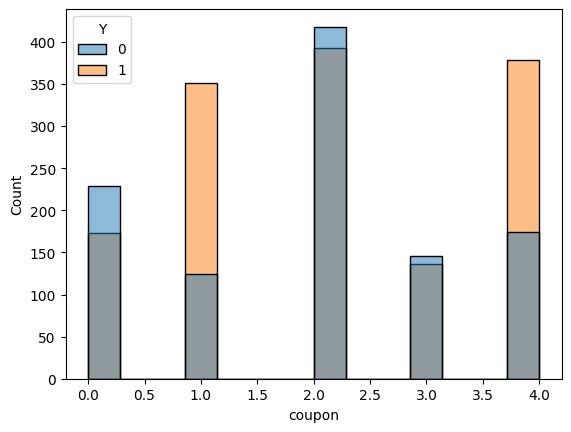

In [ ]:
# Interpretamos el modelo con los datos de prueba
sns.histplot(x=x_test.coupon, hue=y_test)